# Open Mini Challenge: Steuerdaten einer Gemeinde im Kanton Solothurn
## Frage 1

**Erstellt eine Prognose der Steuererträge absolut und pro Person für die nächsten 10 Jahre unter Berücksichtigung allfälliger zyklischer Schwankungen aufgrund der historischen Steuererträge, ggf. in einer geeigneten Partition der Bevölkerung.**

> Partition: Reiche und Arme

# 1. Bibliotheke importieren

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from helper import *

# 2. Daten einlesen und visualisieren

In [2]:
data = pd.read_csv('../Daten/Steuern_SO.csv', sep=';')
print(data.shape)
data.head(), data.describe()

(21, 3)


(   Jahr  Personen  Steuerbares Einkommen
 0  1998    148329              6551307.0
 1  1999    146773              6732949.0
 2  2000    145022              6588062.0
 3  2001    144154              7037941.0
 4  2002    145781              7156045.0,
               Jahr       Personen  Steuerbares Einkommen
 count    21.000000      21.000000           2.100000e+01
 mean   2008.000000  157675.809524           7.963439e+06
 std       6.204837   11270.600541           8.973828e+05
 min    1998.000000  144154.000000           6.551307e+06
 25%    2003.000000  148329.000000           7.261471e+06
 50%    2008.000000  154909.000000           7.965942e+06
 75%    2013.000000  163634.000000           8.690159e+06
 max    2018.000000  177548.000000           9.293956e+06)

Die Daten enthalten Informationen für die Jahre 1998 bis 2018 und zeigen die Anzahl der Personen sowie das steuerbare Einkommen für jede dieser Jahre. Hier sind einige grundlegende statistische Informationen:

- Jahr: Die Daten umfassen einen Zeitraum von 21 Jahren (1998 bis 2018).

- Personen: Die Anzahl der Personen variiert im Laufe der Jahre mit einem Durchschnitt von etwa 157.676, wobei die niedrigste Anzahl bei 144.154 und die höchste bei 177.548 liegt.

- Steuerbares Einkommen: Das steuerbare Einkommen zeigt Schwankungen, mit einem durchschnittlichen Wert von etwa 7.963.439 CHF, einem Minimum von 6.551.307 CHF und einem Maximum von 9.293.956 CHF.

Als nächstes sollten wir eine explorative Datenanalyse durchführen, um Trends, Muster und zyklische Schwankungen in den Daten zu identifizieren. Dies wird uns helfen, das am besten geeignete Modell für die Prognose auszuwählen. Wir können beispielsweise mit der Visualisierung der Zeitreihen für die Anzahl der Personen und das steuerbare Einkommen beginnen, um ein besseres Verständnis für die Daten zu bekommen. 

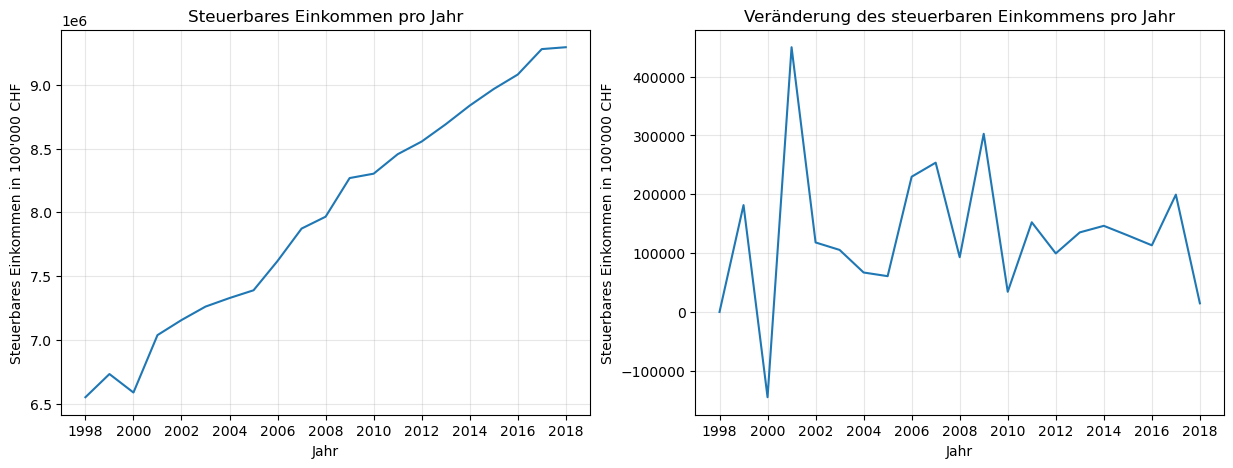

In [3]:
plot_lines(
    df=data,
    x=data['Jahr'],
    y=data['Steuerbares Einkommen'],
    title1='Steuerbares Einkommen pro Jahr',
    title2='Veränderung des steuerbaren Einkommens pro Jahr',
    xlabel='Jahr',
    ylabel='Steuerbares Einkommen in 100\'000 CHF',
    x_ticks = data['Jahr'][::2]
)

- Anzahl der Personen: Es scheint einen allgemeinen Aufwärtstrend in der Anzahl der Personen über den betrachteten Zeitraum zu geben, mit einigen jährlichen Schwankungen.

- Steuerbares Einkommen: Das steuerbare Einkommen zeigt ebenfalls einen Aufwärtstrend, wobei es einige Jahre gibt, in denen das Einkommen besonders hoch oder niedrig ausfällt.

Für die Prognose der Steuererträge für die nächsten 10 Jahre müssen wir ein Modell auswählen, das sowohl mit Trends als auch mit zyklischen Schwankungen umgehen kann. Basierend auf diesen Beobachtungen könnten wir Modelle wie ARIMA (Autoregressive Integrated Moving Average) oder SARIMA (Seasonal ARIMA) in Betracht ziehen, die für trendabhängige Zeitreihendaten geeignet sind.

Bevor wir das Modell auswählen und trainieren, sollten wir auch überprüfen, ob es notwendig ist, die Daten zu transformieren oder zu differenzieren, um eine Stationarität zu erreichen, was ein wichtiger Schritt bei der Anwendung dieser Modelle ist.

# 3. Test auf Stationarität

Um die Stationarität der Zeitreihendaten zu überprüfen, werden wir zwei Hauptmethoden verwenden:

Visuelle Prüfung: Wir betrachten die Diagramme der Zeitreihen, um Hinweise auf Nicht-Stationarität wie Trends oder saisonale Muster zu erkennen.

Statistische Tests: Wir wenden statistische Tests an, wie z. B. den Augmented Dickey-Fuller-Test (ADF-Test), um die Nullhypothese zu überprüfen, dass die Zeitreihe eine Einheitswurzel hat und somit nicht stationär ist.

In [4]:
adf_test(data['Steuerbares Einkommen'])

Augmented Dickey-Fuller Test:
ADF-Statistik: -4.003652339082215
p-Wert: 0.0013915068209952712
Kritische Werte: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}



In [5]:
adf_test(data['Personen'])

Augmented Dickey-Fuller Test:
ADF-Statistik: 1.4829787793857814
p-Wert: 0.9974603435576747
Kritische Werte: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}



### Interpretation
- Für das steuerbare Einkommen ist der p-Wert niedrig (0.0014). Diese Zeitreihe ist sehr wahrscheinlich stationär.
- Für die Anzahl der Personen ist der p-Wert sehr hoch (0.9975), was bedeutet, dass wir die Nullhypothese der Nicht-Stationarität nicht ablehnen können. Die Zeitreihe ist wahrscheinlich nicht stationär.

### Nächste Schritte
- Für das steuerbare Einkommen scheint keine weitere Transformation notwendig zu sein, da die Zeitreihe bereits stationär zu sein scheint.
- Für die Zeitreihe der Anzahl der Personen sollten wir eine Differenzierung oder eine andere Transformation in Betracht ziehen, um Stationarität zu erreichen.

In [6]:
# Differenzierung der Zeitreihe der Anzahl der Personen
data['Personen_Differenziert'] = data['Personen'].diff()

# Entfernen der ersten Zeile mit NaN nach der Differenzierung
data_diff = data.dropna()

# ADF-Test für die differenzierte Zeitreihe der Anzahl der Personen
adf_test(data_diff['Personen_Differenziert'])

Augmented Dickey-Fuller Test:
ADF-Statistik: -1.3638273013217772
p-Wert: 0.5994897315157128
Kritische Werte: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}



## 4. Autokorrelationen

Bestimmung der ARIMA-Parameter ($p$, $d$, $q$):
- $p$: Anzahl der Lag-Observationen im Modell (Autoregression).
- $d$: Grad der Differenzierung.
- $q$: Grösse des gleitenden Durchschnittsfensters (Moving Average).

Modelltraining und -anpassung:
- Wir trainieren das ARIMA-Modell mit den historischen Daten des steuerbaren Einkommens.

Modellvalidierung:
- Überprüfung der Modellleistung anhand historischer Daten.

Prognose:
- Erstellen von Prognosen für die nächsten 10 Jahre.

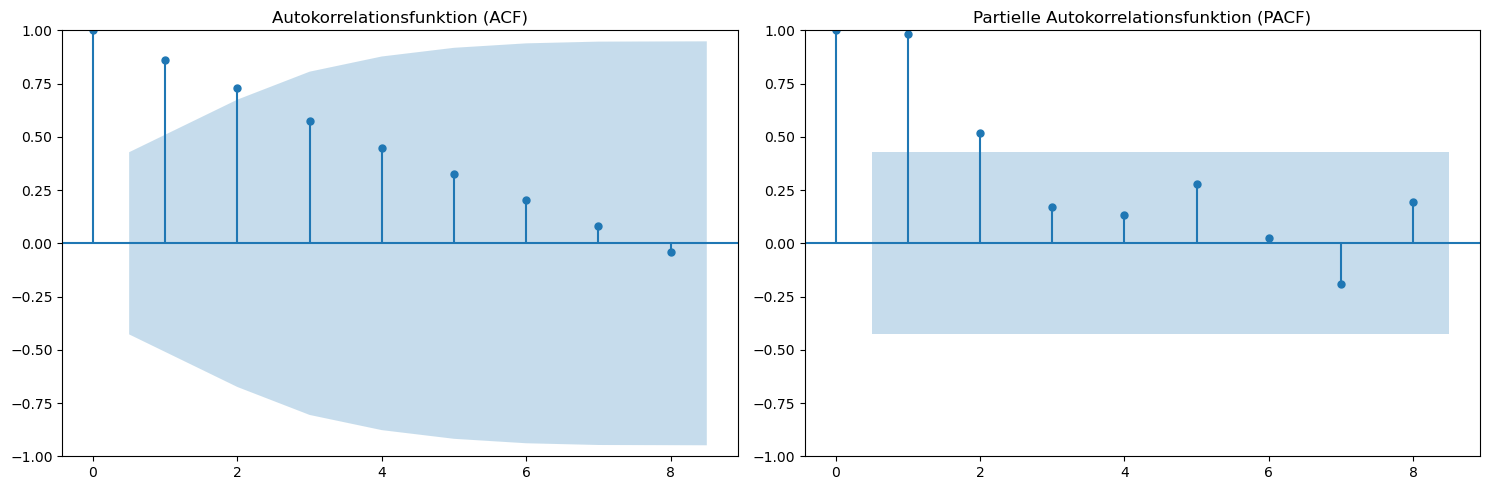

In [7]:
plot_acf_pacf(data['Steuerbares Einkommen'], lags=8)

Die ACF und PACF für die Zeitreihe des steuerbaren Einkommens wurden mit 8 Lags erfolgreich berechnet und dargestellt. Diese Plots helfen uns, die geeigneten Parameter für das ARIMA-Modell zu bestimmen:

**Parameter \( $p$ \) (AR-Teil)**: 
- Bestimmt durch die Anzahl der signifikanten Spitzen im PACF-Diagramm -> 3.
- Eine signifikante Spitze im PACF-Diagramm bei Lag \( k \) deutet darauf hin, dass \( p \) mindestens \( k \) sein könnte.

**Parameter \( $d$ \) (Differenzierung)**:
- Da wir bereits festgestellt haben, dass die Zeitreihe des steuerbaren Einkommens stationär ist, ist der Differenzierungsgrad \( d \) wahrscheinlich 0. Falls wir vorsichtig sein wollen könnten wir auch 1 nehmen.

**Parameter \( $q$ \) (MA-Teil)**:
- Bestimmt durch die Anzahl der signifikanten Spitzen im ACF-Diagramm -> 3.
- Eine signifikante Spitze im ACF-Diagramm bei Lag \( k \) deutet darauf hin, dass \( q \) mindestens \( k \) sein könnte.

## 5. ARIMA-Modell

/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


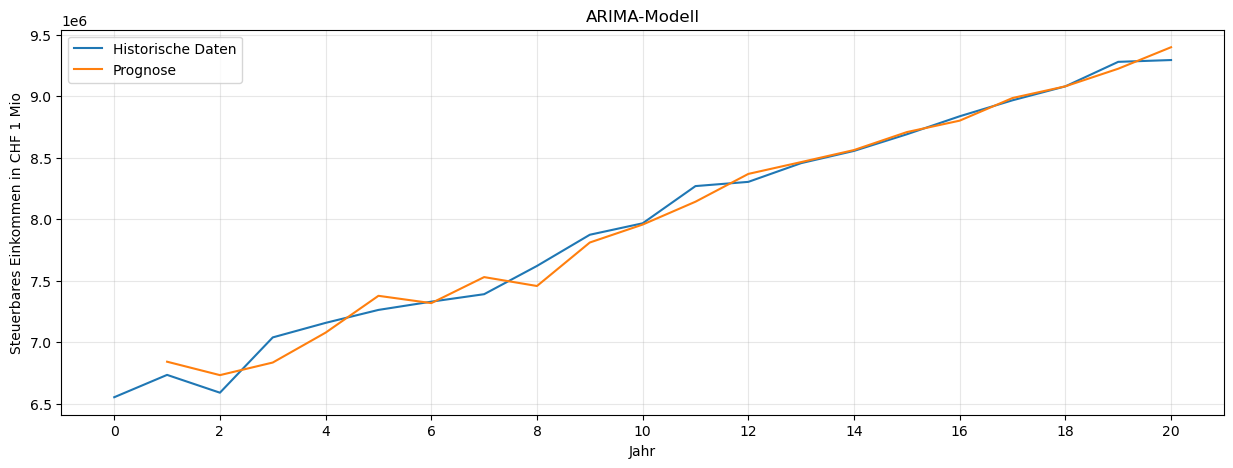

In [8]:
# Festlegen der ARIMA-Modellparameter
p, d, q = 2,1,2

# Trainieren des ARIMA-Modells
arima_result = arima_model(data['Steuerbares Einkommen'], p, d, q)

# Plotten des ARIMA-Modells
plot_arima_model(data['Steuerbares Einkommen'], arima_result, 'ARIMA-Modell', 'Steuerbares Einkommen in CHF 1 Mio')

- Historische Daten: Dargestellt durch die blaue Linie, zeigt die tatsächlichen Werte des steuerbaren Einkommens über die Zeit.

- Prognose/Fitted Values: Dargestellt durch die orange Linie, zeigt die vom ARIMA-Modell angepassten Werte oder Prognosen, die auf den historischen Daten basieren.

Die Fitted Values werden vom ARIMA-Modell generiert und sollen so nah wie möglich an den historischen Daten liegen. Sie repräsentieren, was das Modell basierend auf seiner Struktur (den Parametern $p$, $d$ und $q$) und den ihm gegebenen Daten als den zugrunde liegenden Prozess erkennt.

Wir sehen, dass die Fitted Values die historischen Daten gut abbilden, was bedeutet, dass das Modell die Daten gut erfasst hat. Dies ist ein gutes Zeichen dafür, dass das Modell auch für die Prognose gut funktionieren sollte.

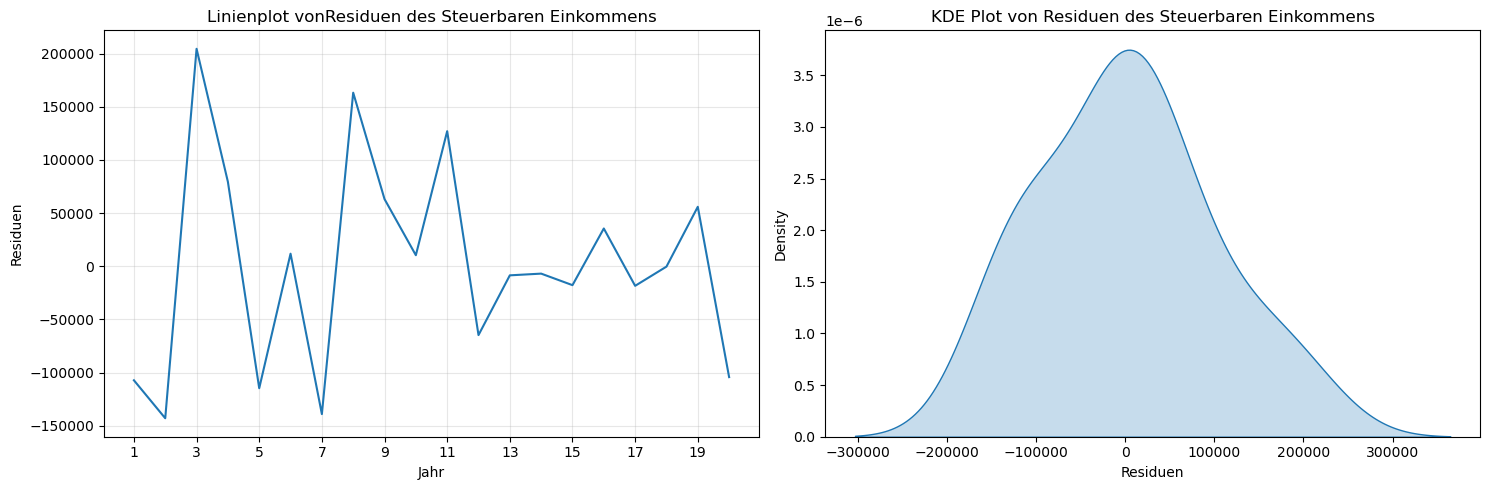

In [9]:
residuals_arima = arima_result.resid[1:]
plot_residuals(residuals_arima, 'Residuen des Steuerbaren Einkommens')

- Zeitreihendiagramm der Residuen: Hier suchen wir nach Mustern oder Trends. Idealerweise sollten die Residuen keine erkennbaren Muster aufweisen und um den Nullwert herum verteilt sein. In diesem Fall scheinen die Residuen relativ zufällig verteilt zu sein, was gut ist.

- KDE Plot der Residuen: Dieses Diagramm hilft uns zu beurteilen, ob die Residuen normalverteilt sind, was ein weiteres Zeichen für ein gut angepasstes Modell wäre. Das Histogramm zeigt eine recht symmetrische Verteilung um den Mittelwert, was darauf hindeutet, dass die Annahme der Normalverteilung der Residuen nicht verletzt wird.

## 6. Vorhersage

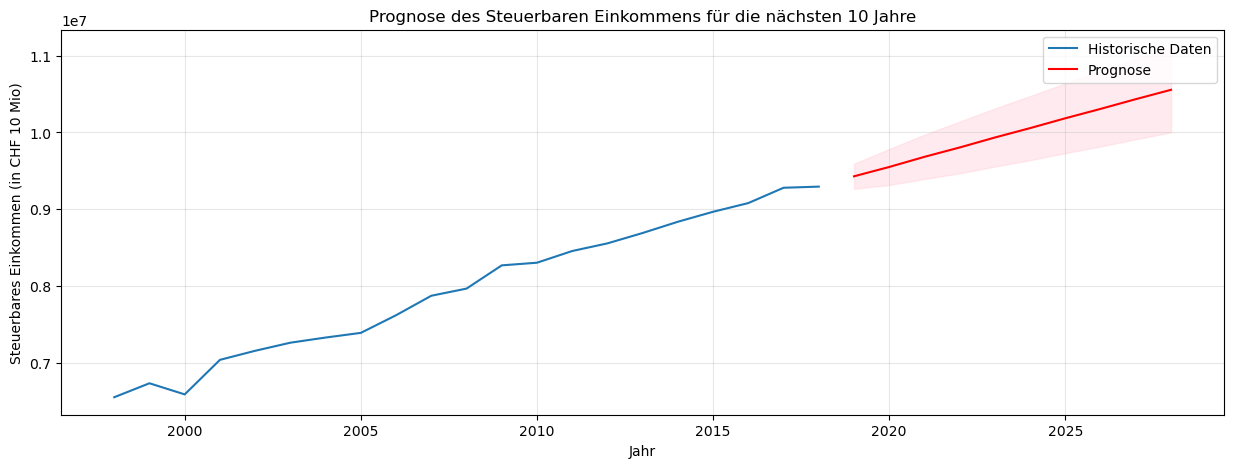

In [10]:
prognose_start, prognose_ende, prognose_mean, prognose_conf_int = get_predictions(10, arima_result, data)

# Visualisierung der Prognose zusammen mit den historischen Daten
plt.figure(figsize=(15, 5))
plt.plot(data['Jahr'], data['Steuerbares Einkommen'], label='Historische Daten')
plt.plot(range(prognose_start, prognose_ende + 1), prognose_mean, label='Prognose', color='red')
plt.fill_between(range(prognose_start, prognose_ende + 1), prognose_conf_int.iloc[:, 0], prognose_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Prognose des Steuerbaren Einkommens für die nächsten 10 Jahre')
plt.xlabel('Jahr')
plt.ylabel('Steuerbares Einkommen (in CHF 10 Mio)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Die Prognose des steuerbaren Einkommens für die nächsten 10 Jahre wurde erfolgreich erstellt und ist im obigen Diagramm dargestellt. In der Grafik sieht man:

- Historische Daten: Die blaue Linie zeigt das steuerbare Einkommen der vergangenen Jahre.

- Prognose: Die rote Linie repräsentiert die prognostizierten Werte des steuerbaren Einkommens für die nächsten 10 Jahre.

- Konfidenzintervall: Der rosafarbene Bereich zeigt das 95% Konfidenzintervall der Prognose. Dies gibt den Bereich an, in dem die tatsächlichen Werte mit einer Wahrscheinlichkeit von 95% liegen sollten.

## 7. Extremwertanalyse

Die Extremwertanalyse ist ein statistischer Ansatz, um die Verteilung von Werten am äussersten Ende des Spektrums zu untersuchen, was besonders wichtig ist, wenn man sich für das Risiko von seltenen Ereignissen interessiert, wie z.B. in der Finanzrisikoanalyse oder bei der Bewertung von Naturkatastrophen.

In [11]:
from scipy import stats

# Shapiro-Wilk-Test zur Überprüfung der Normalverteilung der Residuen
shapiro_test = stats.shapiro(residuals_arima)

# Anzeigen des Ergebnisses des Shapiro-Wilk-Tests
shapiro_test_result = {
    "Wert": shapiro_test[0],
    "p-Wert": shapiro_test[1],
    "Interpretation": "Normalverteilt" if shapiro_test[1] > 0.05 else "Nicht normalverteilt"
}

shapiro_test_result

{'Wert': 0.9591639637947083,
 'p-Wert': 0.5272852778434753,
 'Interpretation': 'Normalverteilt'}

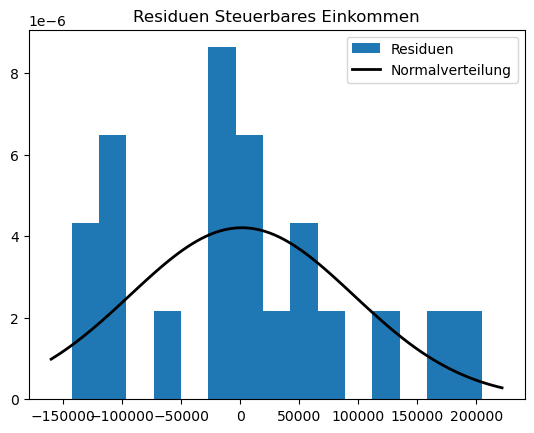

In [12]:
# Histogramm, Normalverteilung
plt.hist(residuals_arima,bins=15, density=True, label='Residuen')
  
from scipy.stats import norm

# Wahrscheinlichkeitsdichte normalverteilt
mu, sig = norm.fit(residuals_arima) 
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sig)
  
plt.plot(x, p, 'k', linewidth=2, label='Normalverteilung')
plt.title('Residuen Steuerbares Einkommen')
plt.legend()
plt.show()

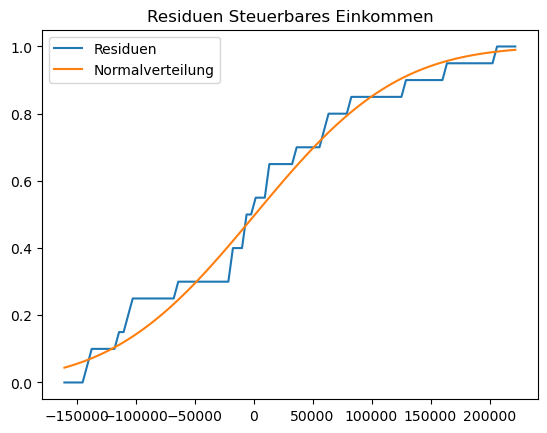

In [13]:
from statsmodels.distributions import ECDF
res_cdf=ECDF(residuals_arima)

plt.plot(x,res_cdf(x),label='Residuen')
plt.plot(x,norm.cdf(x,mu,sig),label='Normalverteilung')
plt.legend()
plt.title('Residuen Steuerbares Einkommen')
plt.show()

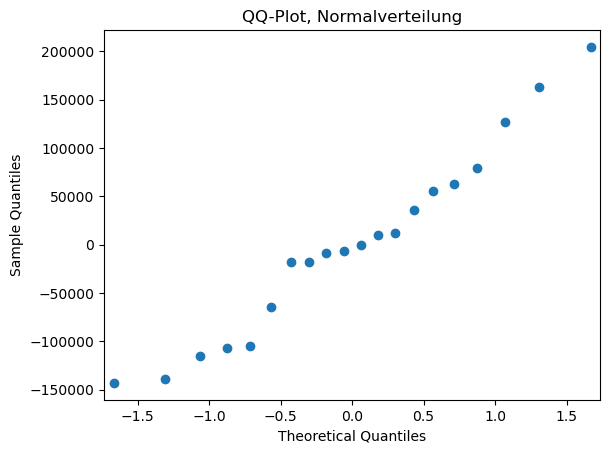

In [14]:
# Quantil-Quantil, Normalverteilung
from statsmodels.api import qqplot
fig = qqplot(residuals_arima, dist=norm)
plt.title('QQ-Plot, Normalverteilung')
plt.show()